# Simulation
Metrics:
- Maximum buffer size
- Washing machine utilization
- Steps taken (for porters)
- Cost (porter cost vs robot cost)
- Bed demand met? (or, how much demand is not met)

Scenarier:
- 1 elevator, 1 vaskeanlæg, poisson arrivals
- N elevatorer, 1 vaskeanlæg, poisson arrivals
- N, elevatorer, 1 vaskeanlæg, variabel poisson arrivals
- 1 akutmodtagelse elevator, N andre elevatorer, 1 vaskeanlæg, variabel poisson arrivals (akutmodtagelse har stort behov for rene senge, genererer ikke mange beskidte)


## Theory
https://en.wikipedia.org/wiki/Erlang_(unit)#Erlang_C_formula

Erlang C formula (for $A < c$):

$$
C(c, A) = \frac{\frac{A^c}{c!} \cdot \frac{c}{c - A}}{\sum_{k=0}^{c-1} \frac{A^k}{k!} + \frac{A^c}{c!} \cdot \frac{c}{c - A}}
$$
where: 
- $c$ is the number of servers (elevators)
- $A$ is the traffic intensity (average number of arrivals per time unit)

$A$ is calculated as:
$$
A = \lambda \cdot T$$
where:
- $\lambda$ is the arrival rate (average number of arrivals per time unit)
- $T$ is the average time a request takes (in this case, the time it takes to wash a bed)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Dark mode settings
plt.style.use('dark_background')

In [ ]:

def plot_queue_length(results):
    plt.figure(figsize=(12, 6))
    plt.title('Queue Length Over Time in Blocking System')
    for run in results:
        plt.plot(run[:, 0], run[:, 1])
    
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.show()


Simulating Replications: 100%|██████████| 5/5 [00:00<00:00, 714.63it/s]

1.22 mean queue length over all runs


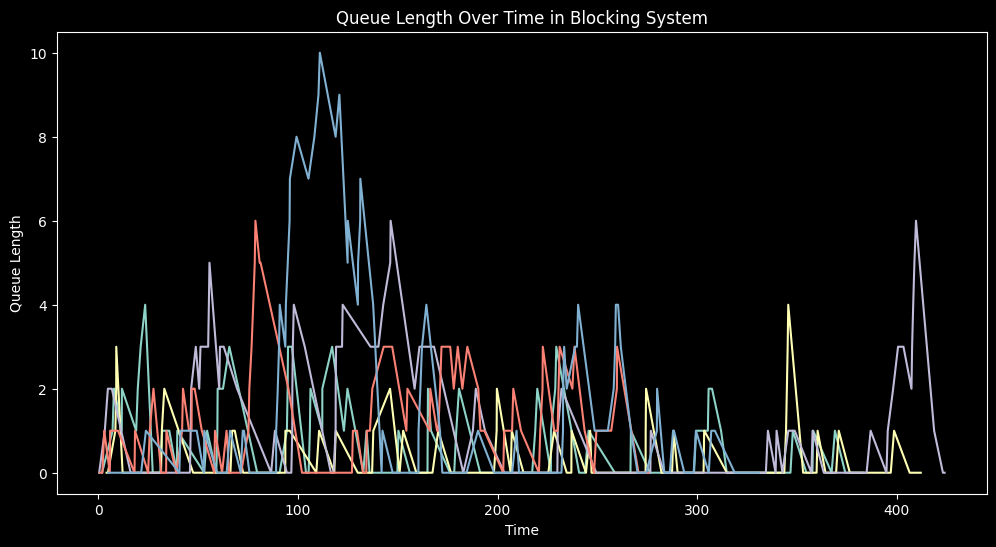

In [156]:
def simulate_erlang_c_one_server(
    max_customers,
    num_replications,
    interarrival_distribution: callable,
    service_distribution: callable,
):
    simulations = []

    for _ in tqdm(range(num_replications), desc="Simulating Replications"):
        time = 0.0
        server_busy_until = 0.0
        queue = np.array([])  # times up to which customers are being served 
        states = []

        for _ in range(max_customers):
            interarrival = interarrival_distribution()
            time += interarrival  # Jump to next arrival time
            service_time = service_distribution()

            # Remove customers who finished before current arrival
            queue = queue[queue > time]
            
            # Calculate the start time for service as current if empty queue, otherwise the max of the queue
            start_service = time if time >= server_busy_until and queue.size == 0 else queue.max() 

            server_busy_until = start_service + service_time
            queue = np.append(queue, server_busy_until)

            queue_length = max(len(queue) - 1, 0)  # exclude the one being served
            states.append((time, queue_length))

        simulations.append(np.array(states))

    return simulations

mu_, T_ = 4, 2  # Arrival rate (4 customers per hour), Service rate (2 hours per customer)
arrival_distribution = lambda: np.random.exponential(mu_)  # Exponential interarrival times (lambda arri)
service_distribution = lambda: np.random.exponential(T_)  # Exponential service (2 hours per customer)
np.random.seed(42)  # For reproducibility
results = simulate_erlang_c_one_server(100, 5, arrival_distribution, service_distribution)
print(f"\033[92m{np.mean([np.mean(run[:, 1]) for run in results]):.2f}\033[0m mean queue length over all runs")  # 1.22
plot_queue_length(results)


In [154]:
np.mean([arrival_distribution() for _ in range(1000)])  # Average interarrival time

0.25877842593165384

In [159]:
def theory_queue_length(mu, T):
    """Theoretical average queue length for Erlang C with one server."""
    rho = 1 / mu / T  # Traffic intensity
    if rho >= 1:
        return float('inf')  # System is unstable
    return (rho ** 2) / (1 - rho)  # Erlang C formula for one server

avg_queue_length = np.mean([np.mean(run[:, 1]) for run in results])
print(f"\033[93m{avg_queue_length:.2f}\033[0m average queue length over all runs")  # 1.22
theoretical_length = theory_queue_length(mu_, T_)
print(f"\033[94m{theoretical_length:.2f}\033[0m theoretical average queue length")  # 1.33

1.22 average queue length over all runs
0.02 theoretical average queue length


In [ ]:
# Erlang C formula for blocking probability
def erlang_c(num_beds, arrival_rate, service_rate):
    traffic_intensity = arrival_rate / service_rate
    numerator = (traffic_intensity ** num_beds) / np.math.factorial(num_beds)
    denominator = sum((traffic_intensity ** k) / np.math.factorial(k) for k in range(num_beds)) + numerator
    return numerator / denominator

erlang_c_prob = erlang_c(100, 0.1, 1)
print(f"Blocking Probability (Erlang C): {erlang_c_prob:.4f}")

Blocking Probability (Erlang C): 0.0000


C:\Users\PC\AppData\Local\Temp\ipykernel_3984\4078179173.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  numerator = (traffic_intensity ** num_beds) / np.math.factorial(num_beds)
C:\Users\PC\AppData\Local\Temp\ipykernel_3984\4078179173.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  denominator = sum((traffic_intensity ** k) / np.math.factorial(k) for k in range(num_beds)) + numerator


-------

In [23]:
def simulate_blocking_system(
    num_beds,       
    num_elevators,  
    num_replications, 
    interarrival_distribution : callable,
    service_distribution : callable,
    ):
    
    blocked_fractions = []

    for _ in tqdm(range(num_replications), desc="Simulating Replications"):
        busy_until = np.zeros(num_elevators)  # Track when each server will be free (was num_beds)
        blocked = 0

        arrival_time = 0

        for _ in range(num_beds):  # Was num_elevators
            interarrival = interarrival_distribution()  # Get the next interarrival time
            arrival_time += interarrival  # Skip to the next customer's arrival time

            # Free up servers that have completed service
            busy_until[busy_until <= arrival_time] = 0

            if np.count_nonzero(busy_until == 0) > 0:
                # Assign to a free server
                free_index = np.where(busy_until == 0)[0][0]
                service_time = service_distribution()  # Get the service time
                busy_until[free_index] = arrival_time + service_time  # Wait for customer + service time
            else:
                # All servers are busy; customer is blocked
                blocked += 1

        blocked_fraction = blocked / num_elevators
        blocked_fractions.append(blocked_fraction)

    # Mean and 95% confidence interval
    mean_blocked = np.mean(blocked_fractions)
    std_error = np.std(blocked_fractions, ddof=1) / np.sqrt(num_replications)
    ci_low, ci_high = norm.interval(0.95, loc=mean_blocked, scale=std_error)

    return mean_blocked, (ci_low, ci_high), blocked_fractions

arrival_distribution = lambda: np.random.exponential(1/8)  # Exponential interarrival times
service_distribution = lambda: np.random.exponential(1)  # Exponential service
simulate_blocking_system(1000, 10, 10, arrival_distribution, service_distribution)

Simulating Replications: 100%|██████████| 10/10 [00:00<00:00, 111.08it/s]


(11.99,
 (10.566883780871805, 13.413116219128195),
 [15.5, 13.9, 12.8, 13.9, 11.1, 12.8, 9.2, 9.8, 12.5, 8.4])